# Start Spark Session

In [1]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import matplotlib.pyplot as plt

conf = pyspark.SparkConf().setAll([('spark.master', 'local[2]'),
                                   ('spark.app.name', 'Basic Setup')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-30 22:43:08,472 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# params
load_cleaned = False

## Load Data

Read data from the `movies.csv` file

In [3]:
if load_cleaned:
    m_path      = 'file:///home/work/data/cleaned_movies'
    g_dist_path = '../../data/cleaned_genre_dist.png'
    g_prop_path = '../../data/cleaned_genre_prop.png'
    y_dist_path = '../../data/cleaned_year_prop.png'
else:
    m_path      = 'file:///home/work/data/movies.csv'
    g_dist_path = '../../data/genre_dist.png'
    g_prop_path = '../../data/genre_prop.png'

In [4]:
movies_df = spark.read.option("header",True).csv(m_path).cache()
movies_df.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [5]:
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

## Look at data

In [6]:
genres_df = movies_df.select(split("genres","\|").alias("genres"))
genres_df = genres_df.select(explode("genres").alias("word"))
genres_df.show(5, truncate=False)

+---------+
|word     |
+---------+
|Adventure|
|Animation|
|Children |
|Comedy   |
|Fantasy  |
+---------+
only showing top 5 rows



In [7]:
distinct_genres = genres_df.groupBy('word').count().sort(col("count").desc())
print(f"Total distinct genres: {distinct_genres.count()}")
distinct_genres.show(25, truncate=False)

Total distinct genres: 20
+------------------+-----+
|word              |count|
+------------------+-----+
|Drama             |25606|
|Comedy            |16870|
|Thriller          |8654 |
|Romance           |7719 |
|Action            |7348 |
|Horror            |5989 |
|Documentary       |5605 |
|Crime             |5319 |
|(no genres listed)|5062 |
|Adventure         |4145 |
|Sci-Fi            |3595 |
|Children          |2935 |
|Animation         |2929 |
|Mystery           |2925 |
|Fantasy           |2731 |
|War               |1874 |
|Western           |1399 |
|Musical           |1054 |
|Film-Noir         |353  |
|IMAX              |195  |
+------------------+-----+



In [8]:
# create histogram
g = distinct_genres.toPandas()
g["prop"] = (g["count"] / g["count"].sum()) * 100
g["word"][8] = "No Genre" # change (no genres listed) to No Genre

/tmp/ipykernel_3516/378850935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g["word"][8] = "No Genre" # change (no genres listed) to No Genre


## Plot the data

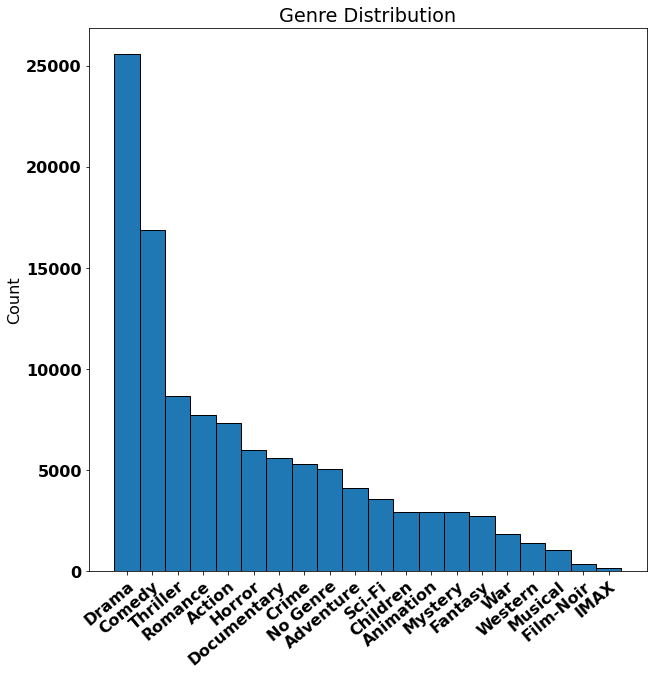

In [9]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)
x = list(range(g.shape[0]))
plt.figure(figsize=(10,10))
plt.bar(g["word"], g["count"],width=1,edgecolor='k')
plt.title("Genre Distribution")
plt.ylabel("Count")
ax = plt.gca()
ax.set_xticks(x, g["word"], rotation=40, ha='right', rotation_mode='anchor')
plt.savefig(g_dist_path)

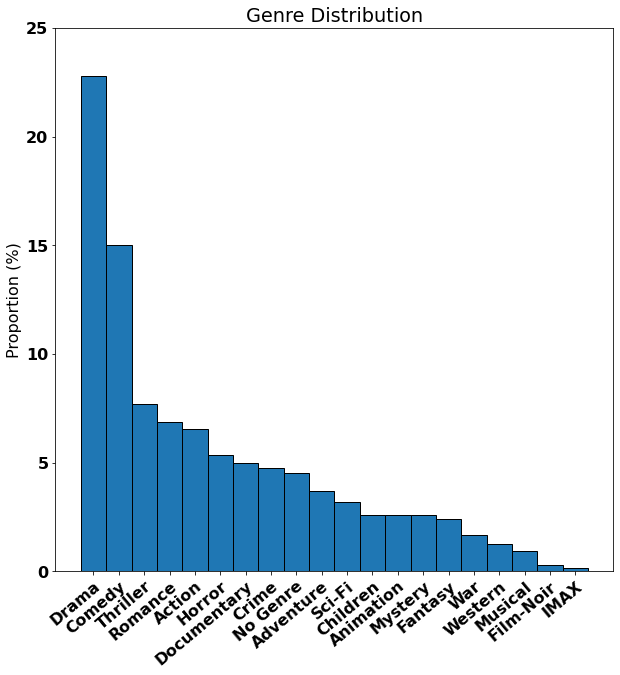

In [10]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)
x = list(range(g.shape[0]))
plt.figure(figsize=(10,10))
plt.bar(g["word"], g["prop"],width=1,edgecolor='k')
plt.title("Genre Distribution")
plt.ylabel("Proportion (%)")
plt.ylim([0,25])
ax = plt.gca()
ax.set_xticks(x, g["word"], rotation=40, ha='right', rotation_mode='anchor')
plt.savefig(g_prop_path)

In [11]:
if load_cleaned:
    movies_df = movies_df.na.drop()
    distinct_years = movies_df.groupBy('movieYear').count().sort(col("movieYear").desc())
    y = distinct_years.toPandas()
    t = y.astype({'movieYear': 'int64'})
    totals = []
    x_tick_labels = []
    year_range = list(range(1870,2021,10))
    grand_total = 0
    for y_i, y_s in enumerate(year_range[:-1]):
        y_e = year_range[(y_i+1)]
        mask = t.where((t.movieYear >= y_s) & (t.movieYear < y_e))
        y_tot = mask['count'].sum()
        totals.append(y_tot)
        grand_total = grand_total + y_tot
        a = str(y_s) + "-" + str(y_e)
        x_tick_labels.append(a)

    x = list(range(len(year_range)-1))
    y_prop = (totals / grand_total) * 100
    plt.figure(figsize=(10,10))
    plt.bar(x, y_prop,width=1,edgecolor='k')
    plt.title("Year Distribution")
    plt.ylabel("Proportion (%)")
    ax = plt.gca()
    ax.set_xticks(x[::2], x_tick_labels[::2], rotation=40, ha='right', rotation_mode='anchor')
    plt.savefig(y_dist_path)

In [12]:
spark.stop()